# dNBR image generation using Landsat
This notebook can be used to generate a delta - Normalised Burn Ratio image (dNBR) image for studing the effect of bushfires.

In [1]:
# Determine what is required and what is not here

import pandas as pd
import geopandas as gpd
import xarray as xr
import sys, os
import time
import multiprocessing
ncpus = multiprocessing.cpu_count()
#from BurnCube import BurnCube #including burn mapping main functions
#bc = BurnCube()

from datacube_stats.statistics import GeoMedian

import datacube
from datacube.storage import masking
#from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import write_geotiff

dc = datacube.Datacube(app='dc_2nd_order_stata')

sys.path.append(os.path.abspath('/g/data/r78/DPIPWE_lm/repos/dea-notebooks/Scripts'))
from dea_bandindices import calculate_indices


'''
#Specify output directory
outputdir = '/g/data/r78/DPIPWE_lm/output_data/'
if not os.path.exists(outputdir):
    print("output directory doesn't exist")
    exit()
'''

'\n#Specify output directory\noutputdir = \'/g/data/r78/DPIPWE_lm/output_data/\'\nif not os.path.exists(outputdir):\n    print("output directory doesn\'t exist")\n    exit()\n'

In [4]:
# Define two queries for the fire affected area, One pre-fire and one-post fire
lat = (-41.68, -41.87)
long = (145.2, 145.5)


query_pre = {
        'lat': lat,
        'lon': long,
        #'crs': 'EPSG:3577',
        #'output_crs': 'EPSG:3577',
        'time': ('2019-01-20')
        }

query_post = {
        'lat': lat,
        'lon': long,
        #'crs': 'EPSG:3577',
        #'output_crs': 'EPSG:3577',
        'time': ('2019-03-01')
        }

In [5]:
# Use the calculate indices script to calculate NBR for images (could also do band math)
dc_data_pre = dc.load(product='ls8_nbart_albers', group_by = 'solar_day', **query_pre)
dc_data_post = dc.load(product='ls8_nbart_albers', group_by = 'solar_day', **query_post)

'''
Band math version

dc_data_pre['NBR'] = (dc_data_pre.nir - ds_data_pre.swir2) / (dc_data_pre.nir + ds_data_pre.swir2)
dc_data_post['NBR'] = (dc_data_post.nir - ds_data_post.swir2) / (dc_data_post.nir + ds_data_post.swir2)
'''

In [ ]:
# Check dataset
dc_data_pre

In [23]:
# Plot the results
#DEAPlotting.rgb(ds=dc_data_pre.isel(time=0), bands = ['swir2', 'nir', 'green'])

<xarray.Dataset>
Dimensions:          (time: 1, x: 1103, y: 927)
Coordinates:
  * time             (time) datetime64[ns] 2019-01-20T23:58:17
  * y                (y) float64 -4.615e+06 -4.615e+06 ... -4.638e+06 -4.638e+06
  * x                (x) float64 1.122e+06 1.122e+06 ... 1.149e+06 1.149e+06
Data variables:
    coastal_aerosol  (time, y, x) int16 234 224 216 225 228 ... 110 129 125 117
    blue             (time, y, x) int16 165 157 147 154 152 ... 63 66 79 81 79
    green            (time, y, x) int16 272 255 266 294 309 ... 220 266 280 256
    red              (time, y, x) int16 196 162 153 160 161 ... 129 157 159 161
    nir              (time, y, x) int16 2200 2350 2425 2417 ... 2492 2418 2229
    swir1            (time, y, x) int16 779 811 852 918 955 ... 685 816 849 804
    swir2            (time, y, x) int16 291 288 298 323 346 ... 256 337 349 333
Attributes:
    crs:      EPSG:3577

In [29]:
# Use the calculate indices function to calculate the NBR for the pre and pos-fire images
NBR_pre = calculate_indices(dc_data_pre, index='NBR', drop=True, collection='ga_ls_3')

NBR_post = calculate_indices(dc_data_post, index='NBR', drop=True, collection='ga_ls_3')

Dropping bands ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']
Dropping bands ['coastal_aerosol', 'blue', 'green', 'red', 'nir', 'swir1', 'swir2']


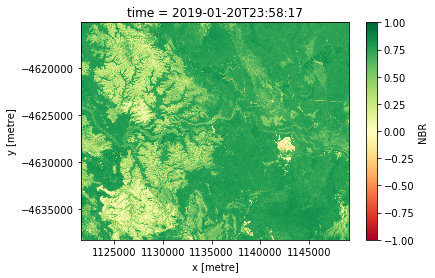

In [30]:
# Plot the results
NBR_pre.NBR.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn')
#ds_NBR_post.NBR.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn')

In [31]:
# Combine the two NBR images into one dataset and look at result
NBR_comb = xr.concat([NBR_pre, NBR_post], dim='time')
NBR_comb

<xarray.Dataset>
Dimensions:  (time: 2, x: 1103, y: 927)
Coordinates:
  * y        (y) float64 -4.615e+06 -4.615e+06 ... -4.638e+06 -4.638e+06
  * x        (x) float64 1.122e+06 1.122e+06 1.122e+06 ... 1.149e+06 1.149e+06
  * time     (time) datetime64[ns] 2019-01-20T23:58:17 2019-03-01T00:04:20
Data variables:
    NBR      (time, y, x) float64 0.7664 0.7817 0.7811 ... 0.7694 0.7307 0.7308
Attributes:
    crs:      EPSG:3577

In [32]:
#Calculate the difference between the two indexes
dNBR = NBR_comb.diff('time')
dNBR

<xarray.Dataset>
Dimensions:  (time: 1, x: 1103, y: 927)
Coordinates:
  * y        (y) float64 -4.615e+06 -4.615e+06 ... -4.638e+06 -4.638e+06
  * x        (x) float64 1.122e+06 1.122e+06 1.122e+06 ... 1.149e+06 1.149e+06
  * time     (time) datetime64[ns] 2019-03-01T00:04:20
Data variables:
    NBR      (time, y, x) float64 -0.02171 -0.03391 ... -0.01701 -0.009292
Attributes:
    crs:      EPSG:3577

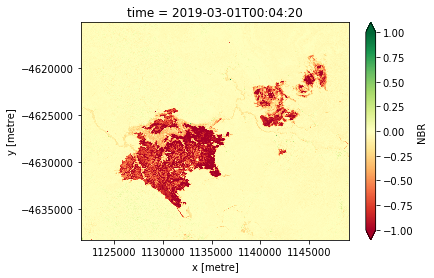

In [34]:
#Plot the delta NBR image

#dNBR
dNBR.NBR.isel(time=0).plot(vmin=-1, vmax=1, cmap='RdYlGn')

In [41]:
# Figure out the correct method of export

#DEADataHandling.dataset_to_geotiff('PIPELINE_ls8_nbart_20160221.tif', dc_data.isel(time=0))
datacube.helpers.write_geotiff(filename='/g/data/r78/DPIPWE_lm/output_data/dNBR.tif', dataset=dNBR.isel(time=0))
#datacube.storage.storage.write_dataset_to_netcdf(dc_diff, 'PIPELINE_ls8_fc_20180125_20160221_diff.nc')